*Important Note:* This file is included as part of the final project submission. It is designed to be run locally (i.e. NOT Colab) only after the necessary dataset downloads have been completed in `dataset_setup.ipynb`, and should only serve as the backup setup method if a local run is deemed necessary.

Description (next two cells):

Install `torchmetrics` for use in Colab environment, and import all necessary libraries for project. For version requirements (handled automatically here in Colab environment), check GitHub repo for `requirements.txt`

In [32]:
import os
import torch
import numpy as np
import cv2
import glob
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import box_iou, MultiScaleRoIAlign
import torch.nn as nn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.optim as optim
import time
import seaborn as sns
from torchmetrics import detection
import pycocotools

Description (next two cells):

Get local image and annotation filepaths and check to make sure a directory exists and count files

In [8]:
def get_image_and_annotation_paths(image_dir, annotation_dir):
  # Use image / annotation paths to map to actual training / testing data
    image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
    annotation_paths = [
        os.path.join(annotation_dir, os.path.basename(p).replace('.jpg', '.txt'))
        for p in image_paths
    ]
    return image_paths, annotation_paths

# Update paths for your train/val/test sets with the correct relative paths
train_image_paths, train_annotation_paths = get_image_and_annotation_paths(
    '../data/VisDrone2019-DET-train/images',
    '../data/VisDrone2019-DET-train/annotations'
)

val_image_paths, val_annotation_paths = get_image_and_annotation_paths(
    '../data/VisDrone2019-DET-val/images',
    '../data/VisDrone2019-DET-val/annotations'
)

test_image_paths, test_annotation_paths = get_image_and_annotation_paths(
    '../data/VisDrone2019-DET-test-dev/images',
    '../data/VisDrone2019-DET-test-dev/annotations'
)

In [9]:
def check_directory(path, file_extension=None):
    if not os.path.exists(path):
        print(f"❌ Path does not exist: {path}")
        return False

    if file_extension:
        files = [f for f in os.listdir(path) if f.endswith(file_extension)]
        print(f"✅ Path exists: {path} (contains {len(files)} {file_extension} files)")
    else:
        files = os.listdir(path)
        print(f"✅ Path exists: {path} (contains {len(files)} files)")

    return True

# Check all directories
print("Checking training directories:")
train_img_dir = '../data/VisDrone2019-DET-train/images'
train_ann_dir = '../data/VisDrone2019-DET-train/annotations'
check_directory(train_img_dir, '.jpg')
check_directory(train_ann_dir, '.txt')

print("\nChecking validation directories:")
val_img_dir = '../data/VisDrone2019-DET-val/images'
val_ann_dir = '../data/VisDrone2019-DET-val/annotations'
check_directory(val_img_dir, '.jpg')
check_directory(val_ann_dir, '.txt')

print("\nChecking test directories:")
test_img_dir = '../data/VisDrone2019-DET-test-dev/images'
test_ann_dir = '../data/VisDrone2019-DET-test-dev/annotations'
check_directory(test_img_dir, '.jpg')
check_directory(test_ann_dir, '.txt')

# Check if the paths match by comparing file counts
print("\nVerifying image and annotation counts match:")
if len(train_image_paths) == len(train_annotation_paths):
    print(f"Training: {len(train_image_paths)} images and annotations match")
else:
    print(f"X Training: {len(train_image_paths)} images but {len(train_annotation_paths)} annotations")

if len(val_image_paths) == len(val_annotation_paths):
    print(f"Validation: {len(val_image_paths)} images and annotations match")
else:
    print(f"X Validation: {len(val_image_paths)} images but {len(val_annotation_paths)} annotations")

if len(test_image_paths) == len(test_annotation_paths):
    print(f"Testing: {len(test_image_paths)} images and annotations match")
else:
    print(f"X Testing: {len(test_image_paths)} images but {len(test_annotation_paths)} annotations")

# Try to access a sample file from each directory (if they exist)
print("\nTrying to access sample files:")
if train_image_paths and train_annotation_paths:
    print(f"Sample training image path: {train_image_paths[0]}")
    print(f"Sample training annotation path: {train_annotation_paths[0]}")

    # Check if the sample files exist
    if os.path.exists(train_image_paths[0]) and os.path.exists(train_annotation_paths[0]):
        print("Sample training files exist")
    else:
        print("X Sample training files don't exist")

Checking training directories:
✅ Path exists: ../data/VisDrone2019-DET-train/images (contains 6471 .jpg files)
✅ Path exists: ../data/VisDrone2019-DET-train/annotations (contains 6471 .txt files)

Checking validation directories:
✅ Path exists: ../data/VisDrone2019-DET-val/images (contains 548 .jpg files)
✅ Path exists: ../data/VisDrone2019-DET-val/annotations (contains 548 .txt files)

Checking test directories:
✅ Path exists: ../data/VisDrone2019-DET-test-dev/images (contains 1610 .jpg files)
✅ Path exists: ../data/VisDrone2019-DET-test-dev/annotations (contains 1610 .txt files)

Verifying image and annotation counts match:
Training: 6471 images and annotations match
Validation: 548 images and annotations match
Testing: 1610 images and annotations match

Trying to access sample files:
Sample training image path: ../data/VisDrone2019-DET-train/images/0000002_00005_d_0000014.jpg
Sample training annotation path: ../data/VisDrone2019-DET-train/annotations/0000002_00005_d_0000014.txt
Samp

Description (next three cells):

Define a Dataset class and perform data pre-processing steps; this class is then utilized to create 3 instances, one for the training, validation, and testing splits.

We then use those objects to create our Dataloaders, such that our data is ready for use in training our model.

Also, remember to select your device GPU here if necessary (default is `cuda`).

In [10]:
class VisDroneDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, resize_to, transforms=None, device='cpu'):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.resize_to = resize_to
        self.transforms = transforms
        self.device = device

        # Skip class 0 ("Ignored") and map valid classes directly
        self.label_remap = {
            1: 1,   # Pedestrian
            2: 2,   # Person
            3: 3,   # Car
            4: 4,   # Van
            5: 5,   # Bus
            6: 6,   # Truck
            7: 7,   # Motor
            8: 8,   # Bicycle
            9: 9,   # Awning-tricycle
            10: 10, # Tricycle
            11: 11  # Other
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        if img is None:
            print(f"[WARN] Failed to load image: {img_path}, skipping.")
            return self.__getitem__((idx + 1) % len(self))

        original_h, original_w = img.shape[:2]

        ann_path = self.annotation_paths[idx]
        boxes, labels = [], []
        try:
            with open(ann_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        vals = list(map(int, line.split(',')))
                        x, y, w, h, cls_id = vals[0], vals[1], vals[2], vals[3], vals[5]

                        if cls_id not in self.label_remap or w <= 0 or h <= 0:
                            continue

                        x1, y1 = x, y
                        x2, y2 = x + w, y + h

                        boxes.append([x1, y1, x2, y2])
                        labels.append(self.label_remap[cls_id])
                    except ValueError:
                        continue
        except FileNotFoundError:
            print(f"[WARN] Annotation not found: {ann_path}, skipping.")
            return self.__getitem__((idx + 1) % len(self))

        if len(boxes) == 0:
            print(f"[WARN] No valid annotations for: {img_path}, skipping.")
            return self.__getitem__((idx + 1) % len(self))

        # Resize image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, self.resize_to)

        # Scale boxes
        scale_x = self.resize_to[0] / original_w
        scale_y = self.resize_to[1] / original_h
        scaled_boxes = [[x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y] for (x1, y1, x2, y2) in boxes]

        img_tensor = torch.tensor(img_resized / 255.0, dtype=torch.float32).permute(2, 0, 1)
        boxes_tensor = torch.tensor(scaled_boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes_tensor, 'labels': labels_tensor}

        if self.transforms:
            img_tensor, target = self.transforms(img_tensor, target)

        return img_tensor.to(self.device), target

In [ ]:
## SELECT PREFERRED GPU HERE DEPENDING ON PERSONAL DEVICE ##

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # This should print "cuda"
"""
# Check if MPS is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")  # This should print "mps"
"""

In [15]:
full_train_dataset = VisDroneDataset(train_image_paths, train_annotation_paths, resize_to=(512, 512), device=device)
full_val_dataset = VisDroneDataset(val_image_paths, val_annotation_paths, resize_to=(512, 512), device=device)
full_test_dataset = VisDroneDataset(test_image_paths, test_annotation_paths, resize_to=(512, 512), device=device)

## UPDATE AS GPU LIMITS PERMIT ##
subset_size = 200 # manually sets size of test subset selected, needed due to many issues with hitting Colab compute limits
# important note: subset_size must not be more than 6471 for training set, 548 for validation set, 1610 for testing set (max image numbers)

# Find valid sample indices for training dataset
valid_indices = []
for i in range(len(full_train_dataset)):
    try:
        img, target = full_train_dataset[i]
        if len(target['boxes']) > 0:
            valid_indices.append(i)
        # Break early for sample testing
        if len(valid_indices) >= subset_size: # * 4 here for more natural train_test_split?
            break
    except Exception:
        continue

train_dataset = Subset(full_train_dataset, valid_indices)

# Find valid sample indices for validation dataset
valid_indices = []
for i in range(len(full_val_dataset)):
    try:
        img, target = full_val_dataset[i]
        if len(target['boxes']) > 0:
            valid_indices.append(i)
        if len(valid_indices) >= subset_size:
            break
    except Exception:
        continue

val_dataset = Subset(full_val_dataset, valid_indices)

# Find valid sample indices for test dataset
valid_indices = []
for i in range(len(full_test_dataset)):
    try:
        img, target = full_test_dataset[i]
        if len(target['boxes']) > 0:
            valid_indices.append(i)
        if len(valid_indices) >= subset_size:
            break
    except Exception:
        continue

test_dataset = Subset(full_test_dataset, valid_indices)

# Create dataloaders for each subset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                                   collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                                    collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,
                                    collate_fn=lambda x: tuple(zip(*x)))

cpu


In [16]:
# Define label map for VisDrone classification
label_map = {
    0: 'Ignored',
    1: 'Pedestrian',
    2: 'Person',
    3: 'Car',
    4: 'Van',
    5: 'Bus',
    6: 'Truck',
    7: 'Motor',
    8: 'Bicycle',
    9: 'Awning-tricycle',
    10: 'Tricycle',
    11: 'Other'
}

Description (next two cells):

We define our Baseline Model based on torchvision's pretrained Faster RCNN ResNet50 with Feature Pyramid Network, which is then trained for `5` epochs.

In [17]:
## BASELINE MODEL

# Load pre-trained Faster R-CNN
baseline_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier for your dataset
num_classes = len(label_map)
in_features = baseline_model.roi_heads.box_predictor.cls_score.in_features
baseline_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to device
baseline_model.to(device)

# Optimizer
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.005)


baseline_model.rpn.pre_nms_top_n_train = 200
baseline_model.rpn.post_nms_top_n_train = 100
baseline_model.rpn.pre_nms_top_n_test = 100
baseline_model.rpn.post_nms_top_n_test = 50

In [18]:
# Training baseline model
num_epochs = 5

for epoch in range(num_epochs):
    baseline_model.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and loss calculation
        loss_dict = baseline_model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")


# Simple validation pass
baseline_model.eval()
with torch.no_grad():
    for images, _ in valid_loader:
        images = [img.to(device) for img in images]
        outputs = baseline_model(images)
        break

Epoch 1/5: 100%|██████████| 50/50 [07:37<00:00,  9.14s/it]


Epoch 1 Loss: 90.5851


Epoch 2/5: 100%|██████████| 50/50 [07:59<00:00,  9.59s/it]


Epoch 2 Loss: 73.8741


Epoch 3/5: 100%|██████████| 50/50 [08:19<00:00,  9.99s/it]


Epoch 3 Loss: 69.2347


Epoch 4/5: 100%|██████████| 50/50 [08:22<00:00, 10.04s/it]


Epoch 4 Loss: 66.2147


Epoch 5/5: 100%|██████████| 50/50 [08:27<00:00, 10.15s/it]


Epoch 5 Loss: 63.5297


Description (next two cells):

We define a `show_prediction` function to visually represent the model's prediction after training. This function is then called on the `baseline_model` as described above.

All successive models use the `show_prediction` function defined here in the same manner.

In [19]:
def show_prediction(img_tensor, pred, label_map=None, score_thresh=0.5):
    # Convert tensor image from [C,H,W] to [H,W,C] and scale if necessary
    img = img_tensor.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()

    print(f"Total predictions = {len(boxes)}")

    has_detections = False
    for box, label, score in zip(boxes, labels, scores):
        if score < score_thresh:
            continue
        has_detections = True

        x1, y1, x2, y2 = box.numpy()
        width, height = x2 - x1, y2 - y1

        rect = patches.Rectangle(
            (x1, y1), width, height,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        label_int = label.item()  # Convert tensor to int
        if label_map and label_int in label_map:
          label_str = label_map[label_int]
        else:
          label_str = str(label_int)

        ax.text(
            x1, y1 - 8, f"{label_str} ({score:.2f})",
            color='yellow', fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5, pad=1, edgecolor='none')
        )

    if not has_detections:
        print(f"No predictions above threshold ({score_thresh})")

    plt.axis('off')
    plt.tight_layout()
    plt.show()

Total predictions = 100


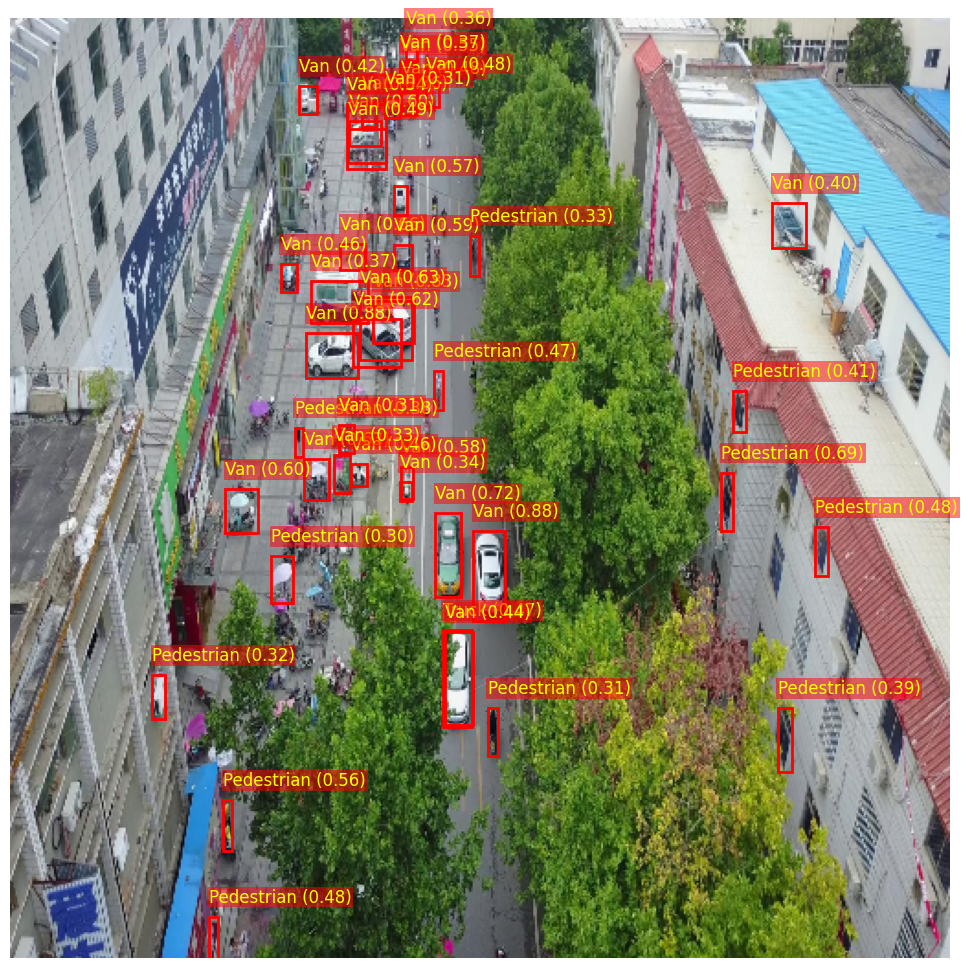

In [20]:
show_prediction(images[0], outputs[0], label_map=label_map, score_thresh=0.3)

Description (next two cells):

We define an `evaluate_model` function to evaluate the model after training, using various metrics such as mAP, recall, precision, F1, and confusion matrix. This function is then called on the `baseline_model` as described above.

All successive models use the `evaluate_model` function defined here in the same manner.

In [33]:
def evaluate_model(model, test_loader, label_map, device=None, iou_threshold=0.5, confidence_threshold=0.5):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()

    map_metric = MeanAveragePrecision(iou_type="bbox")
    tp = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)

    confusion_preds = []
    confusion_gts = []

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)
            map_metric.update(preds, targets)

            for pred, tgt in zip(preds, targets):
                pred_boxes = pred['boxes'].cpu()
                pred_labels = pred['labels'].cpu()
                pred_scores = pred['scores'].cpu()

                gt_boxes = tgt['boxes'].cpu()
                gt_labels = tgt['labels'].cpu()

                # Apply filtering
                keep = pred_scores > confidence_threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                gt_mask = gt_labels != 0
                gt_boxes = gt_boxes[gt_mask]
                gt_labels = gt_labels[gt_mask]

                matched_gt = set()
                ious = box_iou(pred_boxes, gt_boxes) if len(pred_boxes) > 0 and len(gt_boxes) > 0 else torch.zeros((0, 0))

                for i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
                    if ious.shape[0] == 0 or ious.shape[1] == 0:
                        fp[pred_label.item()] += 1
                        continue

                    max_iou, max_idx = ious[i].max().item(), ious[i].argmax().item()

                    if (
                        max_iou >= iou_threshold and
                        pred_label == gt_labels[max_idx] and
                        max_idx not in matched_gt
                    ):
                        tp[pred_label.item()] += 1
                        matched_gt.add(max_idx)
                        confusion_preds.append(pred_label.item())
                        confusion_gts.append(gt_labels[max_idx].item())
                    else:
                        fp[pred_label.item()] += 1

                for i, gt_label in enumerate(gt_labels):
                    if i not in matched_gt:
                        fn[gt_label.item()] += 1

    # Print mAP results
    metrics = map_metric.compute()
    print(f"\nmAP (0.50:0.95): {metrics['map']:.6f}")
    print(f"mAP@0.50:        {metrics['map_50']:.6f}")
    print(f"mAP@0.75:        {metrics['map_75']:.6f}")
    print(f"mAP (small):     {metrics['map_small']:.6f}")
    print(f"mAP (medium):    {metrics['map_medium']:.6f}")
    print(f"mAP (large):     {metrics['map_large']:.6f}")

    # Compute and display per-class metrics
    all_classes = sorted(set(tp.keys()) | set(fp.keys()) | set(fn.keys()))
    print("\nClass-wise Precision, Recall, F1:")
    for cls in all_classes:
        t, f_p, f_n = tp[cls], fp[cls], fn[cls]
        precision = t / (t + f_p) if (t + f_p) > 0 else 0.0
        recall = t / (t + f_n) if (t + f_n) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
        print(f"Class {cls:2d} ({label_map.get(cls, str(cls)):<15}) → Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Confusion Matrix
    if confusion_preds and confusion_gts:
        all_labels = sorted(set(confusion_preds + confusion_gts))
        cm = confusion_matrix(confusion_gts, confusion_preds, labels=all_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d',
                    xticklabels=[label_map.get(c, str(c)) for c in all_labels],
                    yticklabels=[label_map.get(c, str(c)) for c in all_labels],
                    cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
    else:
        print("\n[INFO] No predictions matched ground truth for confusion matrix.")


In [34]:
evaluate_model(baseline_model, test_loader, label_map, iou_threshold=0.4, confidence_threshold=0.2)

ModuleNotFoundError: `MAP` metric requires that `pycocotools` or `faster-coco-eval` installed. Please install with `pip install pycocotools` or `pip install faster-coco-eval` or `pip install torchmetrics[detection]`.

Description (next four cells):

We define our Iteration Model 1 based on torchvision's pretrained Faster RCNN ResNet101 (instead of ResNet50) with Feature Pyramid Network, which is then trained for `5` epochs.

We then show a sample prediction image and evaluate the model as before.

In [ ]:
## ITERATION 1 MODEL ##

# Load pre-trained Faster R-CNN
backbone1 = resnet_fpn_backbone('resnet101', pretrained=True)  # weights='DEFAULT'

# pass this backbone into FasterRCNN
num_classes = len(label_map)
model1 = FasterRCNN(backbone1, num_classes=num_classes)

# Replace the classifier for your dataset

in_features = model1.roi_heads.box_predictor.cls_score.in_features
model1.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to device
model1.to(device)

# Optimizer
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.005)

model1.rpn.pre_nms_top_n_train = 200
model1.rpn.post_nms_top_n_train = 100
model1.rpn.pre_nms_top_n_test = 100
model1.rpn.post_nms_top_n_test = 50

In [ ]:
# Training iteration 1 model
num_epochs = 5

for epoch in range(num_epochs):
    model1.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and loss calculation
        loss_dict = model1(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {epoch_loss:.4f}")

# Simple validation pass
model1.eval()
with torch.no_grad():
    for images, _ in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model1(images)
        break

In [ ]:
show_prediction(images[0], outputs[0], label_map=label_map, score_thresh=0.3)

In [ ]:
evaluate_model(model1, test_loader, label_map, iou_threshold=0.4, confidence_threshold=0.2)

Description (next four cells):

We define our Iteration Model 2 based on torchvision's pretrained Faster RCNN ResNet50 again with Feature Pyramid Network. This time, we implement a learning rate scheduler as well as SGD with Momentum optimizer (for trainable parameters). We also increase the threshold for Non-Maximum Suppression to allow for more overlapping boxes. This model is then trained for `5` epochs.

We then show a sample prediction image and evaluate the model as before.

In [ ]:
## ITERATION 2 MODEL ##

# Load a pre-trained Faster R-CNN model
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Define number of classes (including background)
num_classes = len(label_map)
in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

# Optimizer
params2 = [p for p in model2.parameters() if p.requires_grad]
optimizer2 = torch.optim.SGD(params2, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=3, gamma=0.1)

# Reduce number of region proposals to improve speed
model2.rpn.pre_nms_top_n_train = 1000
model2.rpn.post_nms_top_n_train = 300
model2.rpn.pre_nms_top_n_test = 500
model2.rpn.post_nms_top_n_test = 100

In [ ]:
# Train model 2
num_epochs = 5
for epoch in range(num_epochs):
    model2.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Record epoch loss
        loss_dict = model2(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} loss: {epoch_loss:.4f}")
    lr_scheduler.step()

# Validation pass
model2.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model2(images)
        break

In [ ]:
show_prediction(images[0], outputs[0], label_map=label_map, score_thresh=0.3)

In [ ]:
evaluate_model(model2, test_loader, label_map, iou_threshold=0.4, confidence_threshold=0.2)

Description (next four cells):

We define our Iteration Model 2 based on torchvision's pretrained Faster RCNN ResNet50 again with Feature Pyramid Network. This time, we implement a learning rate scheduler as well as SGD with Momentum optimizer (for trainable parameters). We also increase the threshold for Non-Maximum Suppression to allow for more overlapping boxes. More importantly, we define a full suite custom deep learning architecture as presented in class. This model adds a two layer MLP with dropout regularization in the hopes of training on the shrunken class label prediction head. In addition, we adjust the default AnchorGenerator to capture images with smaller subjects, that we suspect will be more useful for drone imagery. A Region of Interest Pooler is defined to better capture multiple scales in the training imagery, which we find to be common among the many differing settings the VisDrone challenge is compiled from. This model is then trained for `5` epochs.

We then show a sample prediction image and evaluate the model as before.

In [ ]:
## ITERATION 3 MODEL ##

class TwoMLPHeadWithDropout(TwoMLPHead):
    def __init__(self, in_channels, representation_size, dropout_prob=0.5):
        super().__init__(in_channels, representation_size)

        # Inject dropout after the two FC layers
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc6(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc7(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        return x


def get_custom_fasterrcnn_model(num_classes, dropout_prob):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)

    # define cusotm anchor generator with smaller sizes to capture distant aerial photos
    anchor_generator = AnchorGenerator(
        sizes=((16,), (32,), (64,), (128,), (256,)),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    # define custom Roi align to work better with images of different scale
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    # compile above into model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    # replace roi heads with custom MLP layers with dropout
    in_features = model.roi_heads.box_head.fc6.in_features
    model.roi_heads.box_head = TwoMLPHeadWithDropout(
        in_channels=in_features,
        representation_size=1024,
        dropout_prob=dropout_prob
    )

    # replace predictor head as final step
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


num_classes = len(label_map)
model3 = get_custom_fasterrcnn_model(num_classes=num_classes, dropout_prob=0.2)
model3.to(device)

# Optimizer
params3 = [p for p in model3.parameters() if p.requires_grad]
optimizer3 = torch.optim.SGD(params3, lr=0.01, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=2, gamma=0.6)

# Reduce number of region proposals to improve speed
model3.rpn.pre_nms_top_n_train = 1000
model3.rpn.post_nms_top_n_train = 300
model3.rpn.pre_nms_top_n_test = 500
model3.rpn.post_nms_top_n_test = 100

In [ ]:
# Train model 3
num_epochs = 5
for epoch in range(num_epochs):
    model3.train()
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Record epoch loss
        loss_dict = model3(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} loss: {epoch_loss:.4f}")
    lr_scheduler.step()

# Validation pass
model3.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model3(images)
        break

In [ ]:
show_prediction(images[0], outputs[0], label_map=label_map, score_thresh=0.3)

In [ ]:
evaluate_model(model3, test_loader, label_map, iou_threshold=0.4, confidence_threshold=0.2)